# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="./Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import random
import math
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent

In [7]:
def maddpg(n_episodes=5000, max_t=1000, print_every=50, train_mode=True,
         actor_ckpt_path='checkpoints/actor_checkpoint.pth', critic_ckpt_path='checkpoints/critic_checkpoint.pth'):
    
    scores_deque = deque(maxlen=100)
    scores_list = []
    rolling_avgs = []
    max_score = 0
    
    for i_episode in range(1, n_episodes + 1):
        
        env_info = env.reset(train_mode=train_mode)[brain_name]     
        states = env_info.vector_observations                 
        scores = np.zeros(num_agents)                         
        
        agent.reset()
        
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         # get all next states for each agents
            rewards = env_info.rewards                         # get all rewards for each agents
            dones = env_info.local_done                        # get all finished status for each agent
            
            agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states                               
            scores += rewards                        
            
            if np.any(dones): 
                break
                
        scores_deque.append(np.max(scores))
        scores_list.append(np.max(scores))
        
        rolling_avg = np.mean(scores_deque) # calculate average from score window
        rolling_avgs.append(rolling_avg)
        
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, rolling_avg), end="")
                
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, rolling_avg))
                        
        if rolling_avg >= 0.5:
            print('\nProblem Solved in {} episodes.\tAverage Score: {:.4f}'.format(i_episode, rolling_avg))
            torch.save(agent.actor_local.state_dict(), actor_ckpt_path)
            torch.save(agent.critic_local.state_dict(), critic_ckpt_path)
            break
            
    return scores_list, rolling_avgs

In [8]:
methods = [
    { 'label': 'MADDPG (64 nodes)', 'nodes': 64, 'save_name': 'maddpg_64_checkpoint' },
    { 'label': 'MADDPG (128 nodes)', 'nodes': 128, 'save_name': 'maddpg_128_checkpoint' },
    { 'label': 'MADDPG (256 nodes)', 'nodes': 256, 'save_name': 'maddpg_256_checkpoint' },
    { 'label': 'MADDPG (512 nodes)', 'nodes': 512, 'save_name': 'maddpg_512_checkpoint' },
]

In [9]:
data = []
for ii in range(len(methods)):
    method = methods[ii]
    print('Starting {}'.format(method['label']))
        
    # Reset environment
    env_info = env.reset(train_mode=True)[brain_name]

    # Train the agent
    agent = Agent(
        state_size=state_size,
        action_size=action_size,
        n_agents=num_agents,
        random_seed=0,
        layer_1=method['nodes'],
        layer_2=method['nodes'],
    )

    scores, avgs = maddpg(
        n_episodes=5000,
        max_t=1000,
        print_every=50,
        actor_ckpt_path="checkpoints/{}_actor.pth".format(method['save_name']),
        critic_ckpt_path="checkpoints/{}_critic.pth".format(method['save_name'])
    )

    data.append({
        "title": method['label'],
        "scores": scores,
        "avgs": avgs,
    })

Starting MADDPG (64 nodes)
Episode 50	Average Score: 0.0020
Episode 100	Average Score: 0.0010
Episode 150	Average Score: 0.0000
Episode 200	Average Score: 0.0000
Episode 250	Average Score: 0.0000
Episode 300	Average Score: 0.0000
Episode 350	Average Score: 0.0000
Episode 400	Average Score: 0.0000
Episode 450	Average Score: 0.0000
Episode 500	Average Score: 0.0000
Episode 550	Average Score: 0.0107
Episode 600	Average Score: 0.0107
Episode 650	Average Score: 0.0000
Episode 700	Average Score: 0.0000
Episode 750	Average Score: 0.0000
Episode 800	Average Score: 0.0000
Episode 850	Average Score: 0.0000
Episode 900	Average Score: 0.0000
Episode 950	Average Score: 0.0000
Episode 1000	Average Score: 0.0000
Episode 1050	Average Score: 0.0000
Episode 1100	Average Score: 0.0000
Episode 1150	Average Score: 0.0000
Episode 1200	Average Score: 0.0000
Episode 1250	Average Score: 0.0010
Episode 1300	Average Score: 0.0039
Episode 1350	Average Score: 0.0066
Episode 1400	Average Score: 0.0095
Episode 1450	

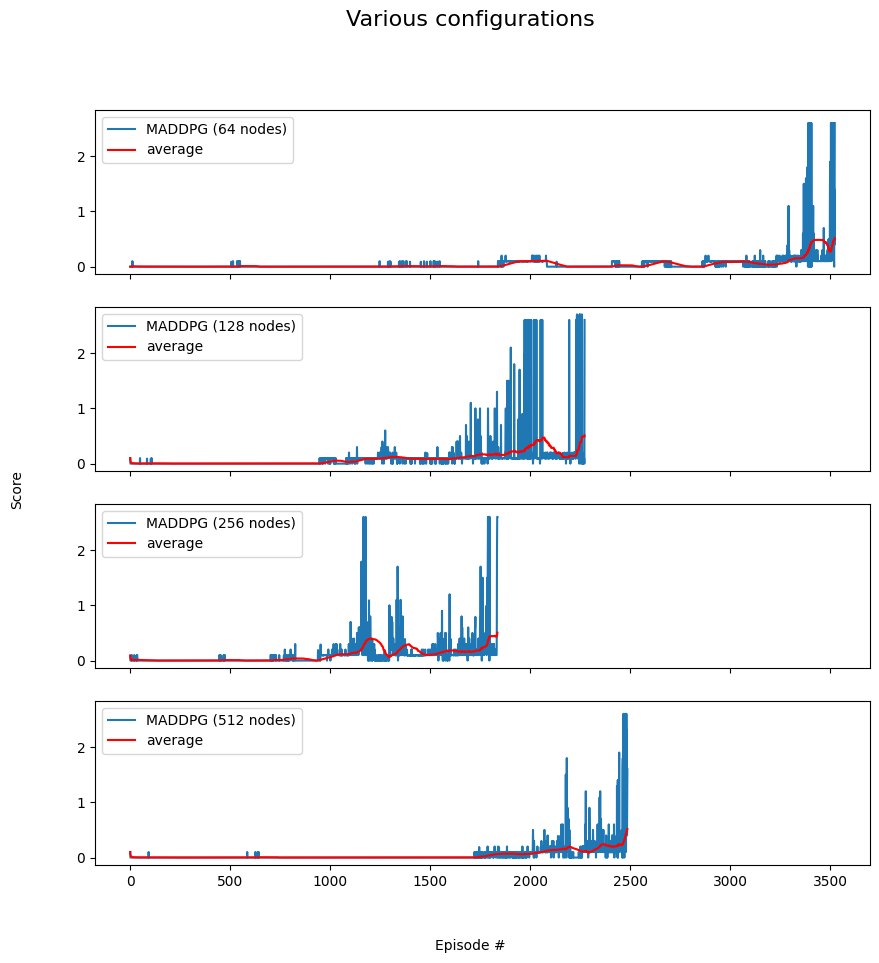

In [26]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10), dpi=100, sharex=True, sharey=True)
fig.suptitle('Various configurations', fontsize=16)
fig.text(0.5, 0.04, 'Episode #', ha='center')
fig.text(0.04, 0.5, 'Score', va='center', rotation='vertical')

for ii in range(len(data)):
    axs[ii].plot(np.arange(len(data[ii]['scores'])), data[ii]['scores'], label=data[ii]['title'])
    axs[ii].plot(np.arange(len(data[ii]['avgs'])), data[ii]['avgs'], c='r', label='average')

    axs[ii].legend(loc='upper left');

#### Run the best agent

In [7]:
# Create agent
agent = Agent(
        state_size=state_size,
        action_size=action_size,
        n_agents=num_agents,
        random_seed=0,
        layer_1=256,
        layer_2=256,
    )

In [9]:
# Load saved weights
checkpoint = './best_agent_maddqg_256_checkpoint.pth'
agent.actor_local.load_state_dict(torch.load(checkpoint))

Episode 1	Average Score: 0.00
Episode 2	Average Score: 0.00
Episode 3	Average Score: 0.00
Episode 4	Average Score: 0.00
Episode 5	Average Score: 0.00
Episode 6	Average Score: -0.00
Episode 7	Average Score: -0.00
Episode 8	Average Score: -0.00
Episode 9	Average Score: -0.00
Episode 10	Average Score: -0.00
Episode 11	Average Score: -0.00
Episode 12	Average Score: -0.00
Episode 13	Average Score: -0.00
Episode 14	Average Score: -0.00
Episode 15	Average Score: -0.00
Episode 16	Average Score: -0.00
Episode 17	Average Score: -0.00
Episode 18	Average Score: -0.00
Episode 19	Average Score: -0.00
Episode 20	Average Score: -0.00


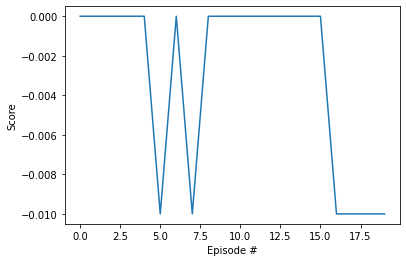

In [10]:
num_episodes = 20
scores = []
for i_episode in range(1,num_episodes + 1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    states = env_info.vector_observations             # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(states)               # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished

        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            scores.append(score)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
            break

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
env.close()